# Analysis of comment moderation results (A/B/C policies)

This notebook:

- Loads:
  - `../data/comments.csv`
  - `../results/comments_with_policy_results.csv`
- Computes:
  - Overall distribution of decisions (BLOCK / WARN_AND_ALLOW / ALLOW) per policy
  - Average tone and debate-value scores per policy
  - Decision maps in tone–debate space (scatter + BLOCK probability heatmap)
  - Cases where policies disagree (e.g., A=BLOCK, C=ALLOW)
- Produces:
  - Summary tables (for slides / report)
  - Optional simple visualizations (bar charts, scatter plots, heatmaps) using matplotlib

Assumptions:

- This notebook is located in `notebooks/` directory of the project.
- Folder structure:

    project_root 
             
      ├─ data/ 
      │   └─ comments.csv 
      ├─ results/ 
      │   └─ comments_with_policy_results.csv 
      └─ notebooks/ 
          └─ analysis_comments_results.ipynb (this file)


In [1]:
# Standard imports
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up paths assuming this notebook is in `notebooks/`
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"

COMMENTS_CSV = DATA_DIR / "comments.csv"
RESULTS_CSV = RESULTS_DIR / "comments_with_policy_results.csv"

print("Project root :", PROJECT_ROOT)
print("Comments CSV :", COMMENTS_CSV)
print("Results CSV  :", RESULTS_CSV)


Project root : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판
Comments CSV : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판\data\comments.csv
Results CSV  : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판\results\comments_with_policy_results.csv


In [2]:
# Load original comments (one row per sample_id)
comments_df = pd.read_csv(COMMENTS_CSV)
print(f"Loaded {len(comments_df)} rows from comments.csv")
display(comments_df.head())

# Load policy results (one row per sample_id x policy)
results_df = pd.read_csv(RESULTS_CSV)
print(f"Loaded {len(results_df)} rows from comments_with_policy_results.csv")
display(results_df.head())

# Merge results with original text so that every row has the comment text
merged_df = results_df.merge(
    comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
    on=["sample_id", "thread_id", "role", "order_in_thread"],
    how="left",
    suffixes=("", "_orig"),
)

print(f"Merged rows: {len(merged_df)}")
display(merged_df.head())


Loaded 182 rows from comments.csv


,sample_id,thread_id,role,order_in_thread,text
0,1,1,post,0,얼마나 인기없으면 글이 안올라오냐
1,2,1,comment,1,뭐?
2,3,1,comment,2,?
3,4,2,post,0,그냥 궁금해서 하는 투표 AI 쓰면 안되는 시험/과제에서 솔직히 쓴 적 있다/없다 ...
4,5,2,comment,1,과제는 많이들 ai 조금이라도 써봤을듯


Loaded 546 rows from comments_with_policy_results.csv


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score
0,1,1,post,0,A,WARN_AND_ALLOW,"강한 비판이지만 특정 인물에 대한 직접적인 모욕이 아니며, 시스템이나 정책에 대한 ...",3,2
1,1,1,post,0,B,WARN_AND_ALLOW,"강한 표현이지만 특정 개인에 대한 직접적인 공격이 아니고, 시스템이나 상황에 대한 ...",3,2
2,1,1,post,0,C,ALLOW,"명확한 위협이나 혐오 표현이 없으며, 자유로운 비판 표현으로 판단됨.",3,2
3,2,1,comment,1,A,ALLOW,"단어 자체가 무례하거나 공격적이지 않고, 인신공격이나 혐오 표현이 없음.",2,1
4,2,1,comment,1,B,ALLOW,"비판적 표현이나 욕설이 없으며, 토론에 기여하는 내용은 적지만 무해함.",2,1


Merged rows: 546


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score,text
0,1,1,post,0,A,WARN_AND_ALLOW,"강한 비판이지만 특정 인물에 대한 직접적인 모욕이 아니며, 시스템이나 정책에 대한 ...",3,2,얼마나 인기없으면 글이 안올라오냐
1,1,1,post,0,B,WARN_AND_ALLOW,"강한 표현이지만 특정 개인에 대한 직접적인 공격이 아니고, 시스템이나 상황에 대한 ...",3,2,얼마나 인기없으면 글이 안올라오냐
2,1,1,post,0,C,ALLOW,"명확한 위협이나 혐오 표현이 없으며, 자유로운 비판 표현으로 판단됨.",3,2,얼마나 인기없으면 글이 안올라오냐
3,2,1,comment,1,A,ALLOW,"단어 자체가 무례하거나 공격적이지 않고, 인신공격이나 혐오 표현이 없음.",2,1,뭐?
4,2,1,comment,1,B,ALLOW,"비판적 표현이나 욕설이 없으며, 토론에 기여하는 내용은 적지만 무해함.",2,1,뭐?


## 1. Decision distribution per policy

Decision counts per policy:


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,153,18,11
B,154,8,20
C,170,4,8


Decision percentages per policy (%):


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,84.1,9.9,6.0
B,84.6,4.4,11.0
C,93.4,2.2,4.4


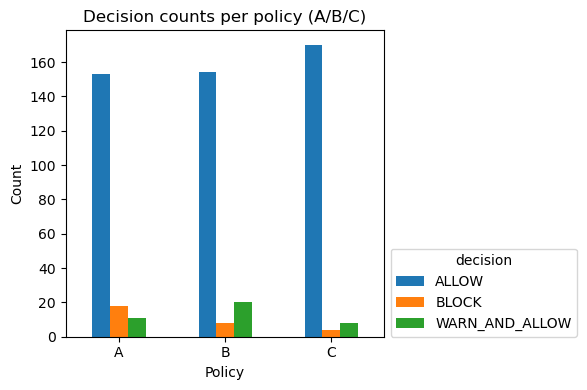

In [3]:
# Decision counts per policy
decision_summary = (
    merged_df
    .groupby(["policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("Decision counts per policy:")
display(decision_summary)

# Also compute row-wise percentages
decision_pct = decision_summary.div(decision_summary.sum(axis=1), axis=0) * 100
print("Decision percentages per policy (%):")
display(decision_pct.round(1))

# Simple bar chart for decision distribution per policy
# (Uses matplotlib only, no custom colors)
ax = decision_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Count")
ax.set_title("Decision counts per policy (A/B/C)")
ax.legend(
    title="decision",
    loc="lower left",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


## 2. Average tone_score and debate_value_score per policy

Average tone_score and debate_value_score per policy:


,tone_score,debate_value_score
policy,,
A,1.75,1.71
B,1.74,1.76
C,1.73,1.76


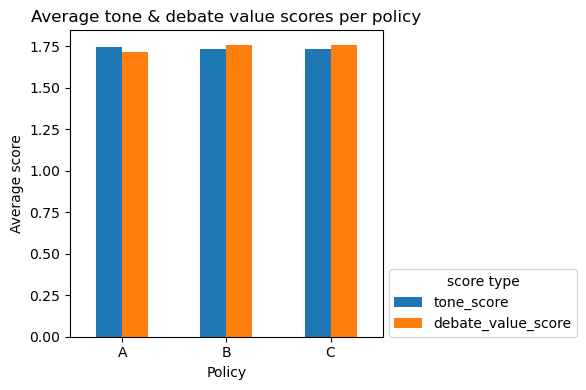

In [4]:
# Average scores per policy
score_summary = (
    merged_df
    .groupby("policy")[["tone_score", "debate_value_score"]]
    .mean()
    .sort_index()
)

print("Average tone_score and debate_value_score per policy:")
display(score_summary.round(2))

# Bar plots for scores (optional)
ax = score_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Average score")
ax.set_title("Average tone & debate value scores per policy")
ax.legend(
    title="score type",
    loc="lower left",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


## 3. Decision maps in tone–debate space

In this section, we visualize how each policy (A/B/C) makes moderation decisions
across the 2D space of **tone_score** (1 = polite, 5 = aggressive) and
**debate_value_score** (1 = low, 5 = high).

We first draw scatter plots (one panel per policy), and then heatmaps showing
the probability of **BLOCK** in each (tone, debate) cell. This reveals which
regions of the space each policy tends to treat more harshly (high BLOCK rate)
or more leniently.


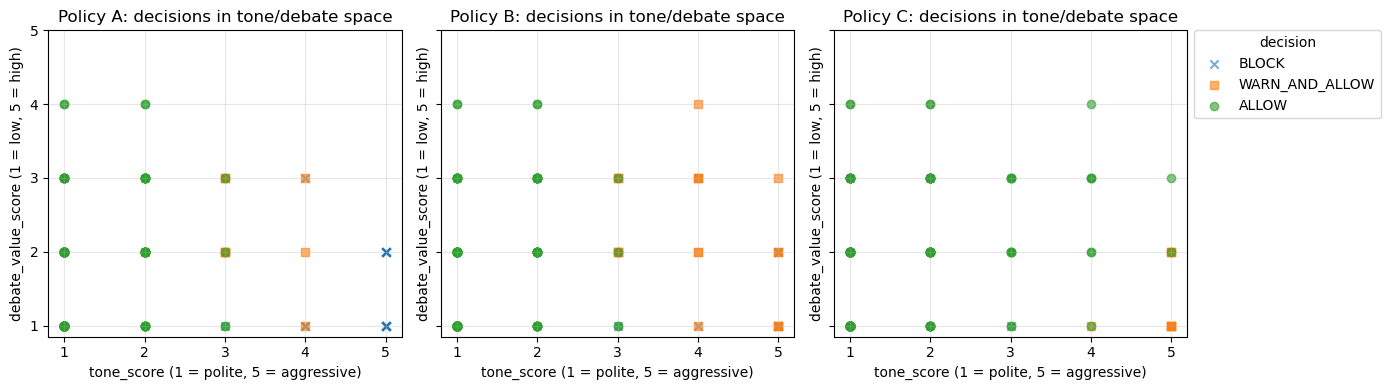

In [10]:
# 3.1 Scatter: decision by tone_score & debate_value_score for each policy

policies = ["A", "B", "C"]
decisions = ["BLOCK", "WARN_AND_ALLOW", "ALLOW"]
markers = {
    "BLOCK": "x",
    "WARN_AND_ALLOW": "s",
    "ALLOW": "o",
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

for ax, pol in zip(axes, policies):
    sub = merged_df[merged_df["policy"] == pol].copy()
    # Drop rows with missing scores
    sub = sub.dropna(subset=["tone_score", "debate_value_score"])

    for dec in decisions:
        sub_dec = sub[sub["decision"] == dec]
        if sub_dec.empty:
            continue
        ax.scatter(
            sub_dec["tone_score"],
            sub_dec["debate_value_score"],
            alpha=0.6,
            marker=markers[dec],
            label=dec,
        )

    ax.set_title(f"Policy {pol}: decisions in tone/debate space")
    ax.set_xlabel("tone_score (1 = polite, 5 = aggressive)")
    ax.set_ylabel("debate_value_score (1 = low, 5 = high)")
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.grid(True, alpha=0.3)

# Legend shown once, on the right of the last panel
axes[-1].legend(
    title="decision",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36768\1645278950.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


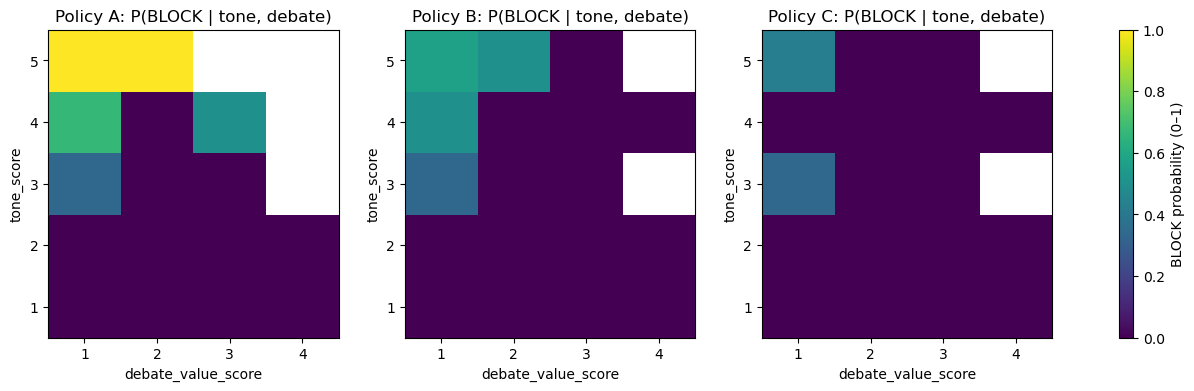

In [11]:
# 3.2 Heatmaps: P(BLOCK | tone_score, debate_value_score) per policy

def make_block_rate_heatmap(df, policy_id):
    """
    Compute P(BLOCK | tone_score, debate_value_score) for a given policy.

    Returns:
        tones: sorted list of tone_score values
        debates: sorted list of debate_value_score values
        block_rate: 2D numpy array with shape (len(tones), len(debates))
    """
    sub = df[df["policy"] == policy_id].copy()
    sub = sub.dropna(subset=["tone_score", "debate_value_score"])

    tones = sorted(sub["tone_score"].unique())
    debates = sorted(sub["debate_value_score"].unique())

    block_rate = np.full((len(tones), len(debates)), np.nan)

    for i, t in enumerate(tones):
        for j, d in enumerate(debates):
            cell = sub[(sub["tone_score"] == t) & (sub["debate_value_score"] == d)]
            if len(cell) == 0:
                continue
            rate = (cell["decision"] == "BLOCK").mean()
            block_rate[i, j] = rate

    return tones, debates, block_rate


import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(
    1, 4,
    width_ratios=[1, 1, 1, 0.05],  
    wspace=0.3,
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])  

last_im = None

for ax, pol in zip(axes, ["A", "B", "C"]):
    tones, debates, block_rate = make_block_rate_heatmap(merged_df, pol)

    im = ax.imshow(
        block_rate,
        origin="lower",
        vmin=0,
        vmax=1,
        aspect="auto",
    )
    last_im = im

    ax.set_title(f"Policy {pol}: P(BLOCK | tone, debate)")
    ax.set_xticks(range(len(debates)))
    ax.set_yticks(range(len(tones)))
    ax.set_xticklabels(debates)
    ax.set_yticklabels(tones)
    ax.set_xlabel("debate_value_score")
    ax.set_ylabel("tone_score")

cbar = fig.colorbar(last_im, cax=cax)
cbar.set_label("BLOCK probability (0–1)")

fig.tight_layout()
plt.show()


## Heatmap 해석: P(BLOCK | tone_score, debate_value_score)

- **x축 (`debate_value_score`)**  
  - 1: 토론 가치 거의 없음 (쓸데없는 싸움/헛소리)  
  - 2–3–4: 토론 가치가 높아질수록, 내용적인 기여가 커지는 방향

- **y축 (`tone_score`)**  
  - 1: 매우 공손  
  - 2: 약간 날카롭지만 크게 공격적이지 않음  
  - 3: 중간 정도의 거친 표현  
  - 4: 꽤 공격적  
  - 5: 매우 공격적/욕설에 가까움

각 칸의 색은 해당 구간에 있는 댓글들 중 **BLOCK 비율 (0~1)** 을 나타낸다.  
하얀 칸은 **그 조합에 해당하는 댓글이 하나도 없어서 (NaN)** 확률을 계산할 수 없는 부분이다.

---

## Policy A

- **tone 1–2**
  - 전체적으로 진한 보라색 → BLOCK 비율 ≈ 0  
  - 공손하거나 살짝 날카로운 수준에서는 거의 차단하지 않음.

- **tone 3**
  - `debate 1`에서만 푸른색 → BLOCK 비율이 눈에 띄게 증가 (대략 0.3~0.4 수준)  
  - 그 외 debate 구간은 거의 0 → “말투가 3이고, 토론 가치도 낮은 댓글”이 주 타깃.

- **tone 4**
  - `debate 1`에서 초록빛 → BLOCK 비율이 0.6~0.7 정도로 상당히 높음.  
  - `debate 3`도 초록빛 → 토론 가치가 어느 정도 있어도, 말투가 4까지 올라가면 꽤 자주 BLOCK.

- **tone 5**
  - `debate 1`, `debate 2`가 노란색에 가까움 → 이 조합에 들어오는 댓글은 거의 **전부 BLOCK (확률 ~1)**  
  - `debate 3`은 데이터 없음(하양).

**요약 (A):**

> - tone ≤ 2: 거의 허용.  
> - tone 3부터 BLOCK이 나타나고, **tone 4 이상 & debate 1–2** 구간은 사실상 BLOCK 존.  
> - debate_value_score가 높아도 tone이 4 이상이면 상당히 공격적으로 막는다.  
>
> ⇒ **“말투 중심의 강경 보호 정책”**  
> (거친 말투에는 토론 가치와 상관없이 강하게 개입하는 편.)

---

## Policy B

- **tone 1–2**
  - 전 구간이 보라색 → BLOCK ≈ 0, A와 비슷하게 온건.

- **tone 3**
  - `debate 1`에서만 푸른색 → BLOCK 비율이 약 0.2~0.3  
  - A보다 색이 연함 → 같은 구간에서 **A보다 덜 막음**.  
  - debate 2~4는 거의 0 → 말투 3이면 웬만하면 허용.

- **tone 4**
  - `debate 1`이 초록색 → BLOCK 비율 0.6~0.7 수준 (꽤 높음).  
  - 나머지 debate 구간은 0 → 토론 가치가 2 이상이면 거의 허용.

- **tone 5**
  - `debate 1`, `debate 2`가 청록/초록 사이 → BLOCK 비율이 0.6~0.8 정도로 높지만,
    A처럼 거의 1.0까지는 가지 않음.  
  - 나머지 debate 구간은 0 또는 데이터 없음.

**요약 (B):**

> - tone 1–2: 거의 모든 댓글 허용.  
> - tone 3: 토론 가치가 매우 낮은(`debate=1`) 경우에만 어느 정도 BLOCK, A보다 느슨함.  
> - tone 4–5: **debate 1(토론 가치 거의 없음)** 에서만 강하게 BLOCK, debate 2 이상이면 대부분 허용.  
>
> ⇒ **“톤과 토론 가치를 같이 보는 중간 수준 정책”**  
> (말투가 거칠어도 토론 가치가 있으면 웬만하면 남겨두는 방향.)

---

## Policy C

- **tone 1–2**
  - 모든 debate 구간에서 BLOCK ≈ 0 → 완전히 관대.

- **tone 3**
  - `debate 1`에서만 살짝 파랗게 → BLOCK 비율 0.2 안팎 정도, 그마저도 낮은 수준.  
  - 나머지 debate 구간은 0.

- **tone 4**
  - 거의 전 구간이 0 → tone 4라도 대부분 허용.

- **tone 5**
  - `debate 1`이 청록색 → BLOCK 비율 0.4~0.5 정도 (절반 전후).  
  - 나머지는 0 또는 데이터 없음.

**요약 (C):**

> - 대부분의 tone–debate 조합에서 BLOCK 확률이 0에 가깝다.  
> - **tone 5 & debate 1**(매우 거친 말투 + 토론 가치 거의 없음)인 경우에만  
>   BLOCK 비율이 절반 정도로 올라간다.  
>
> ⇒ **“거의 방임에 가까운 최소 개입 정책”**  
> (정말 심한 악플 일부만 막고, 나머지는 대부분 그대로 두는 편.)

---

## 세 정책 비교 한 줄 요약

- **Policy A**  
  - tone 4–5 & debate 1–2 구간을 거의 전부 BLOCK → **매너·비하 표현에 매우 민감한 고보호 정책.**

- **Policy B**  
  - 같은 구간에서도 BLOCK 비율이 A보다 낮고, debate가 2 이상이면 많이 풀어줌 →  
    **“토론 가치가 있으면 어느 정도 거친 말투도 허용하는 중간 정책.”**

- **Policy C**  
  - 극단적인 경우(tone 5 & debate 1)조차 BLOCK 비율이 절대 다수는 아니며,  
    나머지는 거의 0 → **“최소 규제, 거의 자유 방임에 가까운 정책.”**


## 4. Cases where policies disagree on decision

In [7]:
# Pivot decisions to one row per sample_id
pivot_decisions = (
    merged_df
    .pivot_table(
        index="sample_id",
        columns="policy",
        values="decision",
        aggfunc="first",
    )
    .sort_index()
)

# Filter rows where not all three policies agree
disagree_mask = pivot_decisions.nunique(axis=1) > 1
disagree_samples = pivot_decisions[disagree_mask].copy()

print(f"Number of samples where policies disagree: {len(disagree_samples)}")
display(disagree_samples.head())

# Attach original text for context
disagree_with_text = (
    disagree_samples
    .reset_index()
    .merge(
        comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
        on="sample_id",
        how="left",
    )
    .sort_values("sample_id")
)

print("Disagreement cases with comment text:")
display(disagree_with_text.head(20))

# Save disagreement cases to CSV for convenient use in slides / report
disagree_path = RESULTS_DIR / "disagreement_cases_with_text.csv"
disagree_with_text.to_csv(disagree_path, index=False, encoding="utf-8-sig")

print("Saved disagreement cases to:", disagree_path)


Number of samples where policies disagree: 25


policy,A,B,C
sample_id,,,
1,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW
21,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW
26,BLOCK,WARN_AND_ALLOW,ALLOW
30,BLOCK,BLOCK,WARN_AND_ALLOW
79,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW


Disagreement cases with comment text:


,sample_id,A,B,C,thread_id,role,order_in_thread,text
0,1,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,1,post,0,얼마나 인기없으면 글이 안올라오냐
1,21,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,4,comment,2,괘씸해서 안받아주지 어짜피 초과학기인데 그냥 다음학기에 들어
2,26,BLOCK,WARN_AND_ALLOW,ALLOW,5,post,0,전전 3.6졸이면 ㅁㅌㅊ임? 전공 성적은 3.9 넘고 기초랑 교양에서 많이 까먹긴함
3,30,BLOCK,BLOCK,WARN_AND_ALLOW,5,comment,4,4.1졸이면 ㅁㅌㅊ임?
4,79,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,7,공군은 그냥 공익아님?
5,80,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,8,헌급방은 빡셈
6,81,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,10,comment,9,빡세도 육군보다는 나음
7,83,WARN_AND_ALLOW,ALLOW,ALLOW,10,comment,11,남자답게 해병대에 입대하자
8,85,BLOCK,BLOCK,WARN_AND_ALLOW,10,comment,13,공군은 사회적으로 나는 폐급이란걸 인정하는거임
9,86,BLOCK,WARN_AND_ALLOW,ALLOW,10,comment,14,라고 사회생활 안해본애가 얘기하는중 ㅋ


Saved disagreement cases to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판\results\disagreement_cases_with_text.csv


## 5. Thread-level decision overview

In [8]:
# For each thread, show how many comments are blocked vs allowed under each policy.

thread_policy_summary = (
    merged_df
    .groupby(["thread_id", "policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values(["thread_id", "policy"])
)

print("Thread-level decision distribution:")
display(thread_policy_summary.head(20))

# Export to CSV if needed
thread_summary_path = RESULTS_DIR / "thread_policy_summary.csv"
thread_policy_summary.to_csv(thread_summary_path, index=False, encoding="utf-8-sig")
print("Saved thread-level summary to:", thread_summary_path)


Thread-level decision distribution:


decision,thread_id,policy,ALLOW,BLOCK,WARN_AND_ALLOW
0,1,A,2,0,1
1,1,B,2,0,1
2,1,C,3,0,0
3,2,A,7,0,0
4,2,B,7,0,0
5,2,C,7,0,0
6,3,A,8,0,0
7,3,B,8,0,0
8,3,C,8,0,0
9,4,A,6,0,1


Saved thread-level summary to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_자유게시판\results\thread_policy_summary.csv
